In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=160)

In [2]:
#mesh = Legendre(50, (0, 20))
mesh = Multidomain(Legendre(20), np.linspace(0, 20, 11))

In [3]:
def kin_energy(v):
    return (v*v).int()/2

def pot_energy(u):
    du_dx = u.diff()
    return (du_dx*du_dx).int()/2

def energy(u, v, method='points'):
    if method == 'precise':
        mesh2 = Legendre(2*mesh.N, mesh.endpoints)
        v = v.remesh(mesh2)
        u = u.remesh(mesh2)
    return kin_energy(v) + pot_energy(u)

In [4]:
def compress(u, v):
    return np.concatenate((u.func, v.func))

def decompress(y):
    func_u, func_v = y.reshape(2, -1)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y.copy())
    
    ut = v

    ux = u.diff()
    bval = (f(t), 0),
    uxx = ux.diff(bval=bval)
    uxx = uxx.match_domains()
    vt = uxx
        
    return compress(ut, vt)

In [5]:
def f(t):
    return 0
matrix_size = 2*np.prod(mesh.shape)
A = np.zeros((matrix_size, matrix_size))
for i, y in enumerate(Progress(np.eye(matrix_size))):
    A[:,i] = derivative(0, y)
e = np.linalg.eigvals(A)
print(np.abs(e.real).max())
print(np.abs(e.imag).max())

HTML(value='')

1.2519841521962473e-06
133.95662961946556


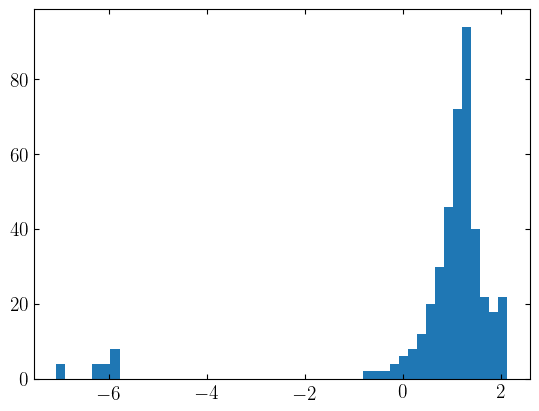

In [6]:
plt.hist(np.log10(np.abs(e.imag) + 1e-10), 50)
plt.show()

# 1D wave equation with impact

In [7]:
%%time
tau = 0.5
t0 = -12*tau
t_max = 30.0
dt = 0.5
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros(mesh.shape))
v0 = TensorField(mesh, np.zeros(mesh.shape))

U = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    return np.exp(-t**2/2/tau**2)
    #return (-1/tau**2 + t**2/tau**4)*np.exp(-t**2/2/tau**2)

def theory(t, x):
    return np.sqrt(np.pi/2)*tau*sp.special.erfc((x - t)/tau/np.sqrt(2))

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-11, atol=1e-13, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

CPU times: user 7 s, sys: 0 ns, total: 7 s
Wall time: 7 s


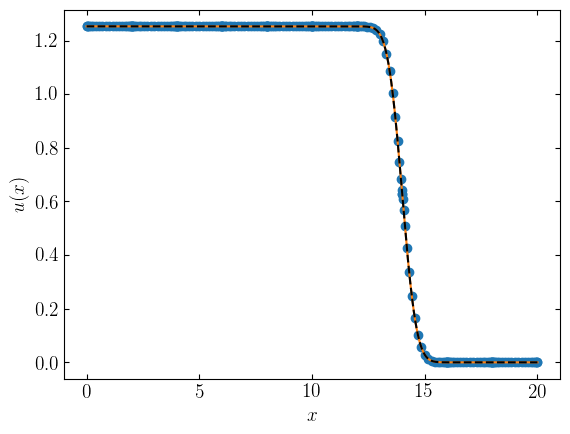

In [9]:
k = 40
u = U[k]
t = T[k]
x = np.linspace(*mesh.endpoints, 1000)
X, = mesh.grid()
plt.plot(X, u.func, 'o')
plt.plot(x, u(x))
plt.plot(x, theory(t, x), 'k--')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.show()

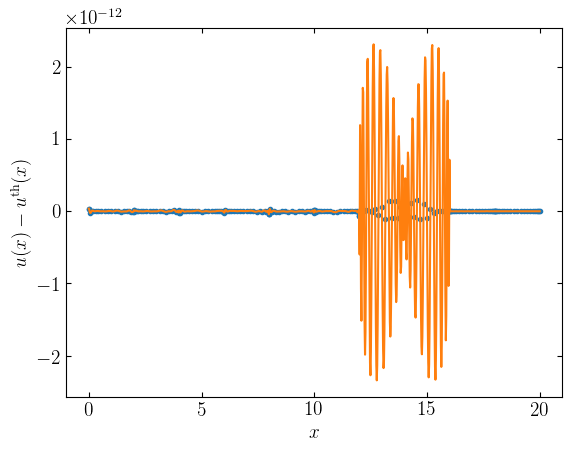

In [10]:
plt.plot(X, u.func - theory(t, X), '.')
plt.plot(x, u(x) - theory(t, x))
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x) - u^{\rm th}(x)$')
plt.show()

In [11]:
np.linalg.norm(u(x) - theory(t, x))/np.linalg.norm(theory(t, x))

5.710763439981175e-13

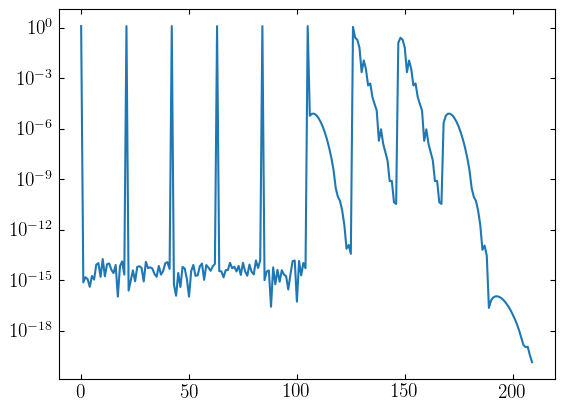

In [12]:
plt.plot(np.abs(u.coeff()))
plt.yscale('log')
plt.show()

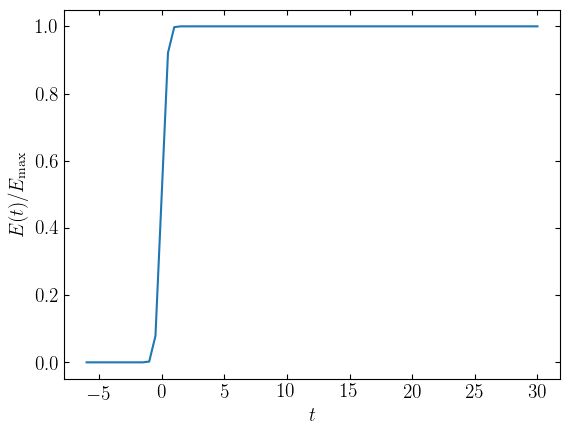

In [13]:
plt.plot(T, E/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()

# Check the energy conservation

In [14]:
%%time
t0 = 0
t_max = 1.0
dt = 0.1
T = np.arange(t0, t_max + dt/2, dt)

u0 = TensorField(mesh, np.random.randn(*mesh.shape))
v0 = TensorField(mesh, 0*np.random.randn(*mesh.shape))

U = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T),) + mesh.shape))
E = np.zeros(len(T))
PE = np.zeros(len(T))

def f(t):
    return 0

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-12, atol=1e-12, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])
    #PE[k] = energy(U[k], V[k], 'precise')

HTML(value='')

CPU times: user 2.71 s, sys: 3.01 ms, total: 2.72 s
Wall time: 2.71 s


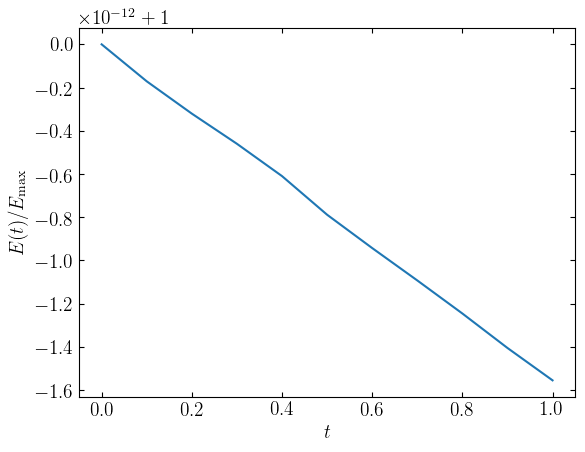

In [15]:
plt.plot(T, E/E.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()

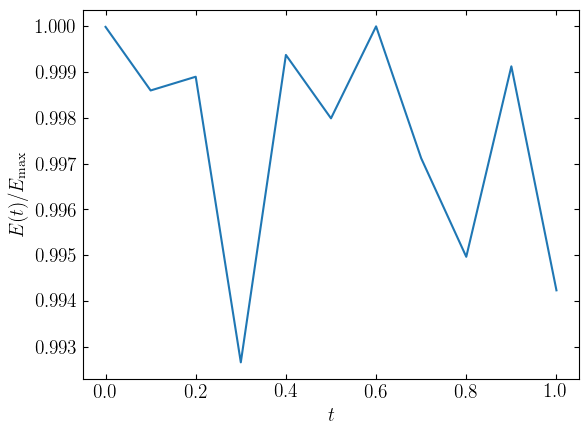

In [19]:
plt.plot(T, PE/PE.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()